# Food Delivery management System
Creating a Model to recommend  a mile  to a customer


## Data Exploratory analysis

### 1. Importing Data

In [53]:
import requests
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:

def fetch_data(url):
    """Fetch data from an API and return a JSON response."""
    try:
        response = requests.get(url, timeout=10)  # Set a timeout for reliability
        response.raise_for_status()  # Raise an error for bad responses (4xx, 5xx)
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None

# API Endpoints
orders_url = "http://127.0.0.1:8000/get_orders"
customers_url = "http://127.0.0.1:8000/get_all_customers"

# Fetch data
orders_data = fetch_data(orders_url)
customers_data = fetch_data(customers_url)

# Create DataFrames if data is available
if orders_data:
    orders_df = pd.DataFrame(orders_data)

    print("Orders DataFrame created successfully!")
    print(orders_df.head())
else:
    print("Failed to create Orders DataFrame.")

if customers_data:
    customers_df = pd.DataFrame(customers_data)
    print("Customers DataFrame created successfully!")
    print(customers_df.head())
else:
    print("Failed to create Customers DataFrame.")


Orders DataFrame created successfully!
                             menu_details  id                 date  \
0      Grilled beef slices in fresh bread   1  2024-04-25T00:00:00   
1           Chicken in creamy curry sauce   2  2024-05-17T00:00:00   
2    Layers of pasta, spinach, and cheese   3  2024-06-04T00:00:00   
3  Beef cooked with vegetables and spices   4  2024-08-23T00:00:00   
4      Rich soup made with ground peanuts   5  2024-02-01T00:00:00   

   customer_id        menu_name   price  
0           21    Beef Sandwich  6000.0  
1           33    Chicken Curry  8000.0  
2          118  Spinach Lasagna  9500.0  
3           32        Beef Stew  8000.0  
4            3      Peanut Soup  4000.0  
Customers DataFrame created successfully!
                                     hashed_password      type  \
0  $2b$12$tAS8Qu6zgMn1axIyLutkA.5NSLgq9KILiylOTvI...  customer   
1  $2b$12$ygt8JYh7VUQE6AIRFipZ5.U.Lt1NrRJgvB7mZ8g...  customer   
2  $2b$12$PcRxjBXJyUVayypvVSzvKOTIsmXLJ7q5.FBBFu

### 2. Merging Datasets  and DataSet Knowledge

In [55]:
# Merge the DataFrames on customer_id and id to match each order to the correct customer
if orders_data and customers_data:
    merged_df = orders_df.merge(customers_df, left_on='customer_id', right_on='id', suffixes=('_order', '_customer'))

    print("Merged DataFrame created successfully!")
    print(merged_df.head())

    # Dataset Analysis
    print("\nDataset Shape or Size")
    print(merged_df.shape)

    print("\nStatistical Information on Dataset")
    print(merged_df.describe())

    print("\nColumns information on Dataset")
    print(merged_df.info())
else:
    print("Failed to merge DataFrames.")

Merged DataFrame created successfully!
                             menu_details  id_order                 date  \
0      Grilled beef slices in fresh bread         1  2024-04-25T00:00:00   
1           Chicken in creamy curry sauce         2  2024-05-17T00:00:00   
2    Layers of pasta, spinach, and cheese         3  2024-06-04T00:00:00   
3  Beef cooked with vegetables and spices         4  2024-08-23T00:00:00   
4      Rich soup made with ground peanuts         5  2024-02-01T00:00:00   

   customer_id        menu_name   price  \
0           21    Beef Sandwich  6000.0   
1           33    Chicken Curry  8000.0   
2          118  Spinach Lasagna  9500.0   
3           32        Beef Stew  8000.0   
4            3      Peanut Soup  4000.0   

                                     hashed_password      type  \
0  $2b$12$zeMgnw75mzuo0JRpSV/5iurSCJJl1nUfr5p8FgB...  customer   
1  $2b$12$f1RRowSMdfWsM51y6O9MruLXzpSTctMiRlpPNHz...  customer   
2  $2b$12$zmZwFAyOxBIdzOX5IMBrXuL5uKPul1IhRGNpy

### 3. Dropping unwanted  features

In [57]:
# Drop unwanted columns (all customer details except ID and menu_details)
columns_to_drop = ['menu_details', 'hashed_password', 'type', 'email', 'role', 'username', 'id_customer']
merged_df = merged_df.drop(columns=columns_to_drop)
print(merged_df.head(10))

   id_order                 date  customer_id        menu_name   price  \
0         1  2024-04-25T00:00:00           21    Beef Sandwich  6000.0   
1         2  2024-05-17T00:00:00           33    Chicken Curry  8000.0   
2         3  2024-06-04T00:00:00          118  Spinach Lasagna  9500.0   
3         4  2024-08-23T00:00:00           32        Beef Stew  8000.0   
4         5  2024-02-01T00:00:00            3      Peanut Soup  4000.0   
5         6  2024-06-27T00:00:00          101   Boiled Cassava  2500.0   
6         7  2024-05-21T00:00:00           26    Chapati Rolls  3500.0   
7         8  2024-10-10T00:00:00          125    Chicken Curry  8000.0   
8         9  2024-08-01T00:00:00          111   Cassava Leaves  5000.0   
9        10  2024-11-08T00:00:00           64  Fried Plantains  3500.0   

     location  
0     Ruhango  
1     Muhanga  
2      Burera  
3      Burera  
4  Nyamasheke  
5      Rusizi  
6      Gasabo  
7     Musanze  
8      Burera  
9     Rulindo  


# Feature Engineering


In [58]:
# Convert date to datetime and extract features
df = merged_df

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

# Price classification (create 3 tiers)
df['price_tier'] = pd.qcut(df['price'], q=3, labels=['Low', 'Medium', 'High'])

# Customer order frequency
cust_order_count = df['customer_id'].value_counts().to_dict()
df['cust_order_freq'] = df['customer_id'].map(cust_order_count)

# Location-menu popularity
loc_menu_pop = df.groupby(['location','menu_name']).size().reset_index(name='loc_menu_count')
df = df.merge(loc_menu_pop, on=['location','menu_name'], how='left')

# Data Encoding

In [59]:
from sklearn.preprocessing import StandardScaler

# Initialize encoders
label_encoders = {}

# Encode categorical variables
categorical_cols = ['menu_name', 'location', 'price_tier']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['day_of_month', 'cust_order_freq', 'loc_menu_count']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Data Visualization


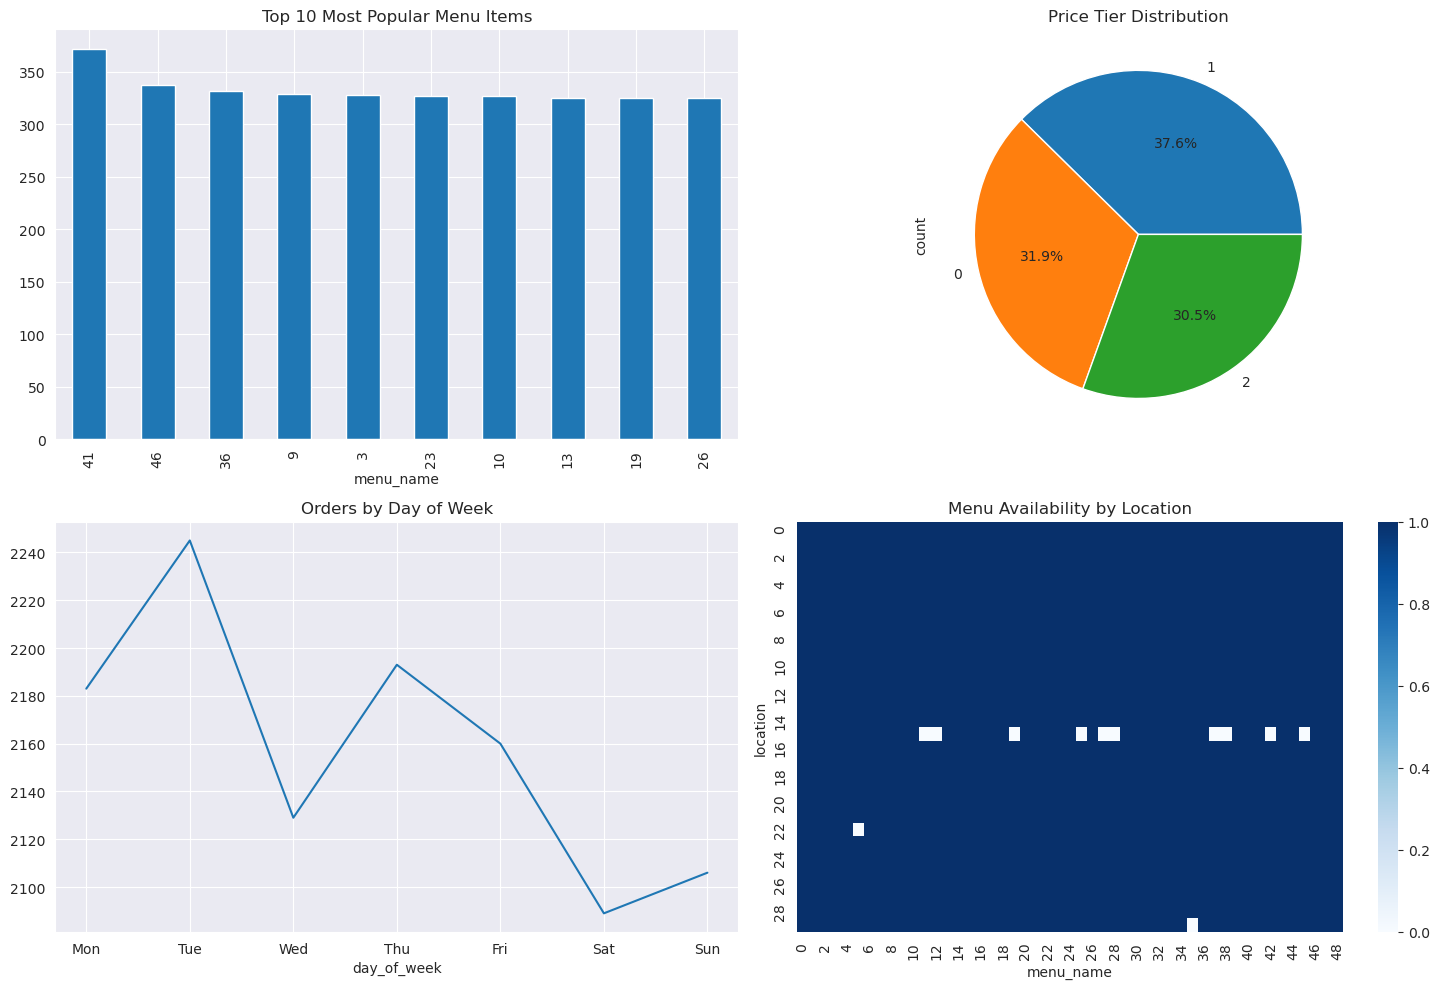

In [60]:
plt.figure(figsize=(15,10))

# Plot 1: Menu popularity
plt.subplot(2,2,1)
df['menu_name'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Most Popular Menu Items')

# Plot 2: Price tier distribution
plt.subplot(2,2,2)
df['price_tier'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Price Tier Distribution')

# Plot 3: Order patterns by day of week
plt.subplot(2,2,3)
df.groupby('day_of_week')['menu_name'].count().plot(kind='line')
plt.title('Orders by Day of Week')
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

# Plot 4: Location heatmap
plt.subplot(2,2,4)
location_menu = df.groupby(['location','menu_name']).size().unstack()
sns.heatmap(location_menu.notnull().astype(int), cmap='Blues')
plt.title('Menu Availability by Location')

plt.tight_layout()
plt.show()

#  Model Development


In [61]:
# Prepare features and target
features = ['month', 'day_of_week', 'is_weekend', 'price_tier',
            'cust_order_freq', 'loc_menu_count', 'location']
X = df[features]
y = df['menu_name']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation


Classification Report:
                     precision    recall  f1-score   support

      Avocado Salad       0.21      0.29      0.24        52
      Avocado Toast       0.42      0.28      0.34        75
    Banana Smoothie       0.11      0.15      0.12        67
     Beef Brochette       0.38      0.26      0.31        66
        Beef Burger       0.15      0.09      0.11        56
         Beef Curry       0.16      0.18      0.17        67
      Beef Sandwich       0.18      0.29      0.22        52
       Beef Sausage       0.29      0.25      0.27        60
          Beef Stew       0.23      0.27      0.25        52
     Boiled Cassava       0.24      0.25      0.25        79
    Boiled Potatoes       0.45      0.32      0.38        47
         Cappuccino       0.40      0.31      0.35        65
     Cassava Leaves       0.20      0.31      0.24        61
      Chapati Rolls       0.20      0.13      0.16        69
    Cheese Sandwich       0.20      0.13      0.16        68


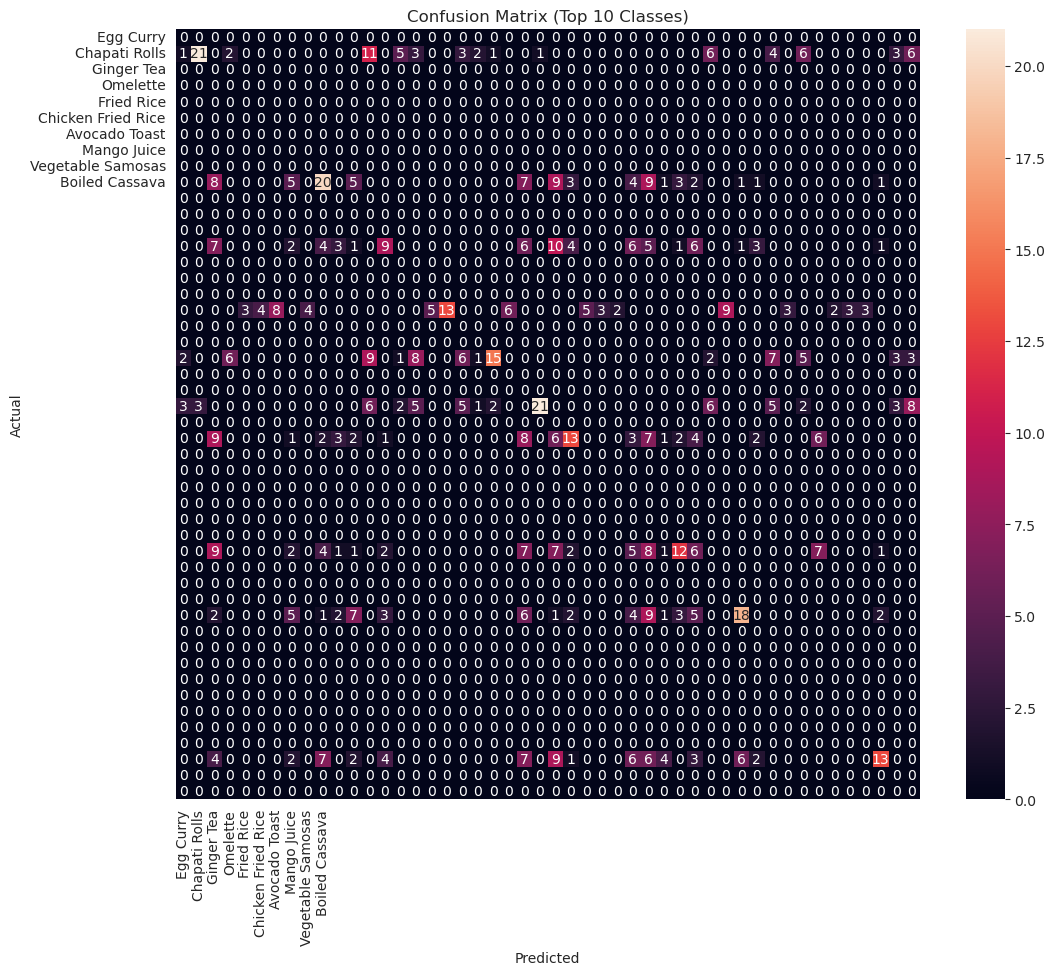

In [62]:
# Get the actual class names
class_names = label_encoders['menu_name'].classes_

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred,
                          target_names=class_names))

# For confusion matrix - let's show top 10 classes to avoid overcrowding
top_classes = np.argsort(np.bincount(y_test))[-10:]  # Get indices of 10 most common classes
mask = np.isin(y_test, top_classes)
cm = confusion_matrix(y_test[mask], y_pred[mask])

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names[top_classes],
            yticklabels=class_names[top_classes])
plt.title('Confusion Matrix (Top 10 Classes)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Model Saving and Deployment

In [64]:
# Save all necessary artifacts
artifacts = {
    'model': model,
    'label_encoders': label_encoders,
    'scaler': scaler,
    'features': features,
    'cust_order_count': cust_order_count,
    'loc_menu_pop': loc_menu_pop
}

joblib.dump(artifacts, 'menu_recommender.joblib')

print("Model and artifacts saved successfully")

Model and artifacts saved successfully


## Recommender Functions

In [65]:
def recommend_menu(customer_id, date, location, top_n=3):
    # Load artifacts
    artifacts = joblib.load('menu_recommender.joblib')
    model = artifacts['model']
    le = artifacts['label_encoders']

    # Prepare input features
    date = pd.to_datetime(date)
    features = {
        'month': date.month,
        'day_of_week': date.dayofweek,
        'is_weekend': int(date.dayofweek in [5,6]),
        'price_tier': 1,  # Default to medium
        'cust_order_freq': artifacts['cust_order_count'].get(customer_id, 1),
        'loc_menu_count': artifacts['loc_menu_pop'].get((location, ''), 1),  # Default value
        'location': le['location'].transform([location])[0]
    }

    # Create DataFrame
    X = pd.DataFrame([features])

    # Get probabilities
    probs = model.predict_proba(X)[0]
    top_indices = np.argsort(probs)[-top_n:][::-1]

    # Return recommendations
    recommendations = []
    for idx in top_indices:
        menu_id = model.classes_[idx]
        menu_name = le['menu_name'].inverse_transform([menu_id])[0]
        confidence = probs[idx]
        recommendations.append((menu_name, float(confidence)))

    return recommendations

[('Ginger Tea', 0.07946524037207851), ('Omelette', 0.07220791292879088), ('Fruit Salad', 0.06787474595163681)]


## Testing the Model

In [66]:
print(recommend_menu(customer_id=21, date='2024-07-15', location='Ruhango'))

[('Ginger Tea', 0.0794652403720785), ('Omelette', 0.07220791292879088), ('Fruit Salad', 0.06787474595163681)]
